In [1]:
## load dependencies if not installed
#!pip install imageio coremltools ipympl numpy

In [2]:
import tensorflow as tf
import os
import sys

import numpy as np
import pydicom
import nibabel as nib
import math
from PIL import Image as im
from IPython.display import display, HTML

import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

print(tf.__version__)
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2.12.0
Metal device set to: Apple M2 Max


In [3]:
#CONSTANTS
DIMS = 256
DISP_NUM = 7
BATCH = 8
EPOCHS = 350
CHANNELS = 3

In [4]:
#Load them all
PathDicom = '/Users/andrew/Dropbox/segment/headct-nifti/labels/final/'
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".nii" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))

Labels = []
Scans = []

for filenameDCM in lstFilesDCM:
    label = nib.load(filenameDCM).get_fdata()
    scan = nib.load(filenameDCM.replace("labels/final/","")).get_fdata()
    shape = tf.shape(label)
    
    if (shape[0] == 512 and shape[1] == 512):
        if (tf.size(Labels) == 0):
            Labels = label
            Scans = scan
        else:
            Labels = np.append(Labels, label, axis=2)
            Scans = np.append(Scans, scan, axis=2)
            Labels = np.append(Labels, np.flip(label,1), axis=2)
            Scans = np.append(Scans, np.flip(scan,1), axis=2)
            scan  = tf.transpose(scan, perm=[1,0,2]).numpy() # 90' Rotation
            label = tf.transpose(label, perm=[1,0,2]).numpy() # 90' Rotation
            Labels = np.append(Labels, label, axis=2)
            Scans = np.append(Scans, scan, axis=2)
            Labels = np.append(Labels, np.flip(label,0), axis=2)
            Scans = np.append(Scans, np.flip(scan,0), axis=2)

In [5]:
# CODE FOR INDIVIDUAL NORMALIZATION
def window_channels(input):
    input[0] = (np.clip(input[0], -4000, -380) + 2190)/1810 # Background
    
    input[1] = (np.clip(input[1], -50, 80) - 15)/65       # Brain window
    # input[1] = (np.clip(input[1], 40, 70) - 55)/15      # Hemmorhage
    
    input[2] = (np.clip(input[2], 80, 2000) - 1040)/960    # Bone window

    # input[3] = (np.clip(input[3], -50, 250) - 100)/150  # SDH
    # input[4] = (np.clip(input[4], 28, 36) - 32)/4       # Stroke
    return input

def preprocess_imgs(input):
   input = np.swapaxes(input, 0, 2)

   # copies data into 3 channels
   input = np.repeat(input[...,np.newaxis],CHANNELS,-1)
   
   # transpose the channels - (channel, slice, 512, 512)
   input = tf.transpose(input, perm=[3,0,1,2]).numpy()
   
   # window the individual channels - (channel, slice, 512, 512)
   input = window_channels(input)     
       
   # return data back as expect (slice, 512, 512, channel)
   return tf.transpose(input, perm=[1,2,3,0]).numpy()

index = 3
label2 = np.swapaxes(tf.image.resize(Labels, (DIMS, DIMS)), 0, 2)
rgb_batch = tf.image.resize(Scans, (DIMS, DIMS))
rgb_batch_copy = tf.identity(np.swapaxes(rgb_batch, 0, 2))
og_train_scan = rgb_batch_copy[index]
rgb_batch = preprocess_imgs(rgb_batch)

In [6]:
# Clean up the background segmentation
background = rgb_batch[:,:,:,0]
background = ( background%1 != 0 ).astype(int)

# Clean up the skin segmentation
skin = rgb_batch[:,:,:,1]
skin = (skin % 1 != 0).astype(int)

label2 = np.where(((background) & (label2!=0)), 0, label2)
# label2 = np.where(((label2==0) & (background==0) & (skin!=0)), 4, label2)

# Clean up bone segmentation
bone = rgb_batch[:,:,:,2]
bone = (bone%1 != 0).astype(int)
label2 = np.where((bone) & (label2 != 0), 3 , label2)
label2 = np.where(((label2 == 3) & (bone != 1)), 4 , label2)

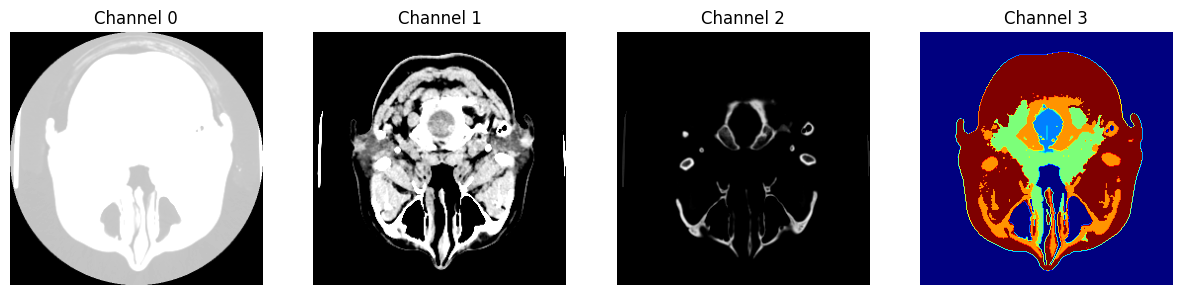

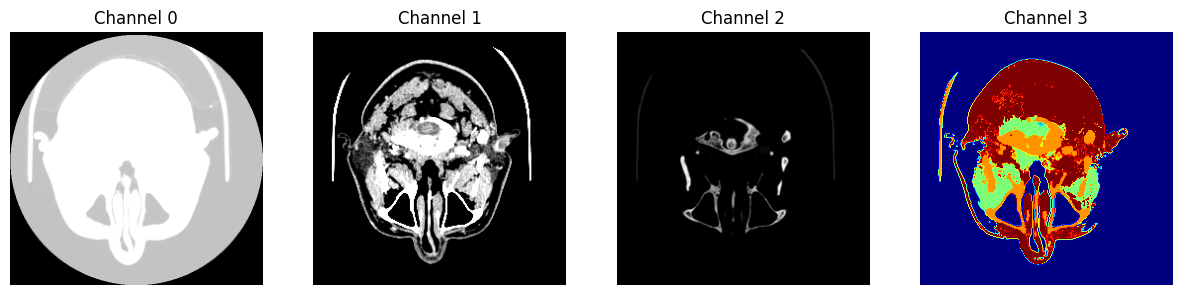

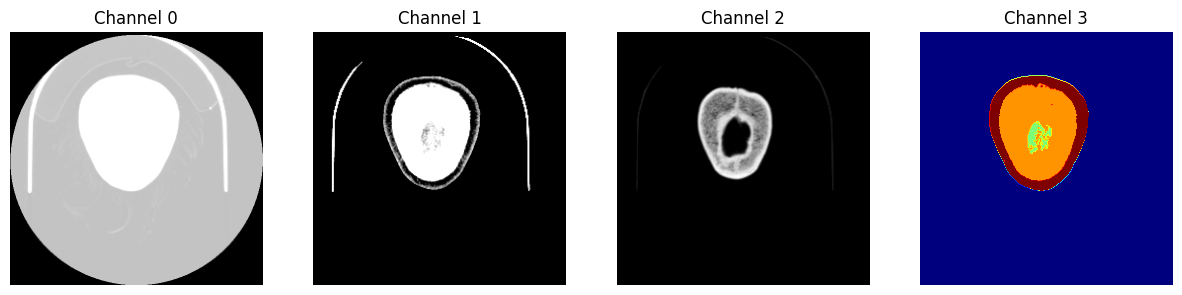

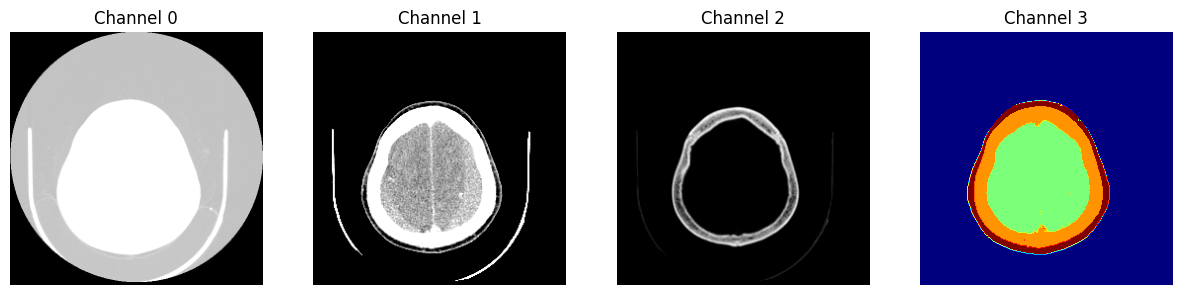

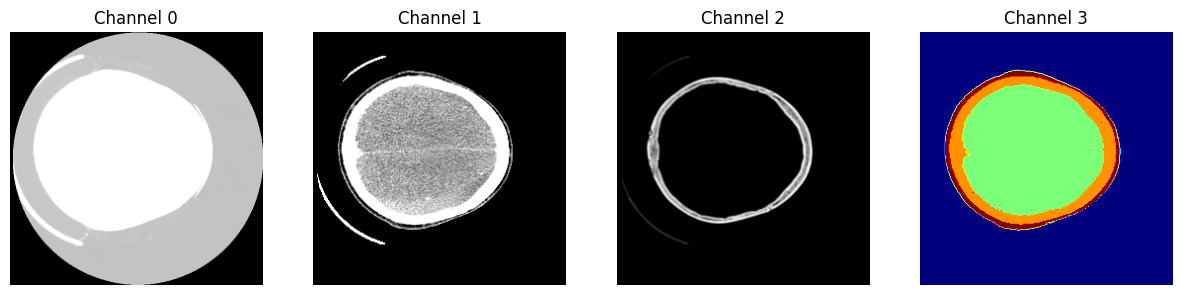

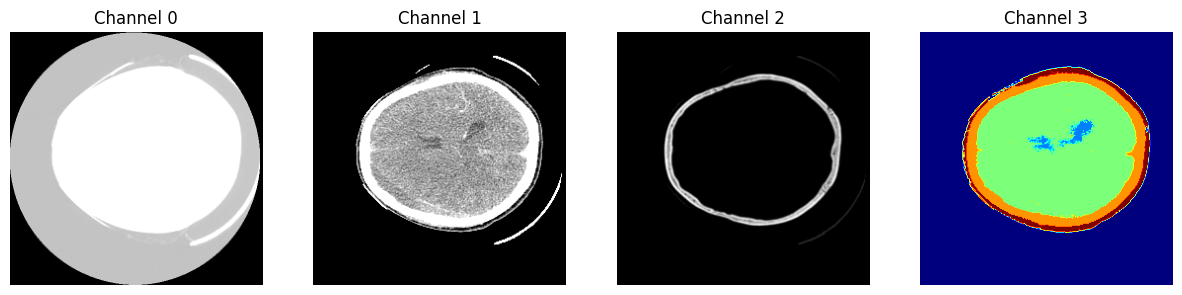

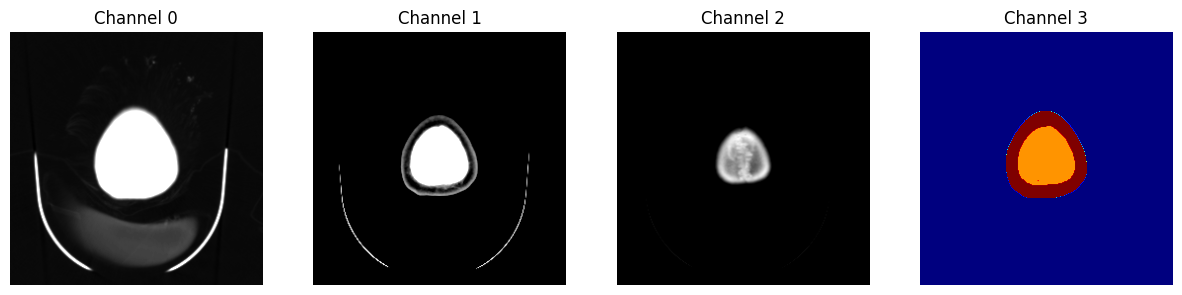

In [7]:
# Display sample data
for sample in range (1, len(rgb_batch), math.floor(len(rgb_batch)/DISP_NUM)):
    f, axarr = plt.subplots(1,CHANNELS+1, figsize = (15,15)) 
    for i, ax in enumerate(axarr):
        if(i<CHANNELS):
            axarr[i].imshow(rgb_batch[sample, :, :,i], 'gist_gray') #, vmin=40, vmax=300)
            # axarr[i].imshow(label2[sample, :, :], 'jet', alpha=0.05)
        else:
            axarr[i].imshow(label2[sample, :, :], 'jet') #, vmin=40, vmax=300)
        axarr[i].axis(False)
        axarr[i].title.set_text('Channel {}'.format(i))

In [8]:
from sklearn.model_selection import train_test_split

# Load a Testing Scan
scan_index = 16
nifti_scan = nib.load('/Users/andrew/Dropbox/segment/headct-nifti/CT9.nii.gz').get_fdata()
resized_nifti_scan = tf.image.resize(nifti_scan, (DIMS, DIMS))
copy_nifti_scan =  tf.identity(np.swapaxes(resized_nifti_scan, 0, 2))
og_scan = copy_nifti_scan[scan_index]
processed_nifti_scan = preprocess_imgs(tf.identity(resized_nifti_scan))
nii_scan = processed_nifti_scan[scan_index]

train_X, val_X,train_y, val_y = train_test_split(rgb_batch, label2, test_size=0.15, 
                                                      random_state=0)

# develop tf Dataset objects
train_X = tf.data.Dataset.from_tensor_slices(train_X)
val_X = tf.data.Dataset.from_tensor_slices(val_X)

train_y = tf.data.Dataset.from_tensor_slices(train_y)
val_y = tf.data.Dataset.from_tensor_slices(val_y)

# verify the shapes and data types

train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec

(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256), dtype=tf.float32, name=None))

In [9]:
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y))

AT = tf.data.AUTOTUNE
#buffersize
BUFFER = 100

STEPS_PER_EPOCH = len(train_X)//BATCH
VALIDATION_STEPS = len(val_X)//BATCH

train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
train = train.prefetch(buffer_size=AT)
val = val.batch(BATCH)

In [10]:
# Use pre-trained DenseNet121 without head
base = tf.keras.applications.DenseNet121(input_shape=[DIMS,DIMS,CHANNELS], 
                                      include_top=False, 
                                      weights='imagenet')

In [11]:
#final ReLU activation layer for each feature map size, i.e. 4, 8, 16, 32, and 64, required for skip-connections
skip_names = ['conv1/relu', # size 64*64
             'pool2_relu',  # size 32*32
             'pool3_relu',  # size 16*16
             'pool4_relu',  # size 8*8
             'relu'        # size 4*4
             ]

#output of these layers
skip_outputs = [base.get_layer(name).output for name in skip_names]
#Building the downstack with the above layers. We use the pre-trained model as such, without any fine-tuning.
downstack = tf.keras.Model(inputs=base.input,
                       outputs=skip_outputs)
# freeze the downstack layers
downstack.trainable = False

In [12]:
import pix2pix

# Four upstack layers for upsampling sizes 
# 4->8, 8->16, 16->32, 32->64 
upstack = [
          pix2pix.upsample(512,CHANNELS),
          pix2pix.upsample(384,CHANNELS),
          pix2pix.upsample(256,CHANNELS),
          pix2pix.upsample(128,CHANNELS),
          pix2pix.upsample(64 ,CHANNELS)]

In [13]:
# define the input layer
inputs = tf.keras.layers.Input(shape=[DIMS,DIMS,CHANNELS])

# downsample 
down = downstack(inputs)
out = down[-1]

# prepare skip-connections
skips = reversed(down[:-1])
# choose the last layer at first 4 --> 8

# upsample with skip-connections
for up, skip in zip(upstack,skips):
    out = up(out)
    out = tf.keras.layers.Concatenate()([out,skip])
    
# define the final transpose conv layer
out = tf.keras.layers.Conv2DTranspose(5, 3,
                                  strides=2,
                                  padding='same',
                                  )(out)
# complete unet model
unet = tf.keras.Model(inputs=inputs, outputs=out)

In [14]:
# compiling the model 
def Compile_Model():
    unet.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.003),
            metrics=['accuracy']) 
    
Compile_Model()

In [15]:
## Plot Training / Test Data

import math 
import matplotlib.gridspec as gridspec
plt.rcParams['figure.figsize'] = (45, 9)

def display_everything(title,  og_scans, scans, labels=None, cols=20, epoch=None):

    display(HTML(title))
    rows = math.ceil(len(scans)/cols)
    r = 2 if labels is None else 4

    for row in range(rows):
        if(row < 1):
            plt.figure(figsize=(1,1))
            gs1 = gridspec.GridSpec(1, 1)
            f, axarr = plt.subplots(r,cols)
            for i in range(cols):
                    index = row * cols + i 
                    spread = math.floor(len(og_scans) / cols) * i
                    # plot the actual image
                    axarr[0, index%cols].imshow(og_scans[spread], cmap='gist_gray',vmin=-5, vmax=65)
                    axarr[0, index%cols].axis('off')

                    # plot the prediction
                    pred = tf.squeeze(unet.predict(tf.expand_dims(scans[spread], 0), verbose=0))
                    axarr[1,index%cols].imshow(tf.argmax(pred, axis=-1),cmap='jet')
                    axarr[1,index%cols].axis('off')

                    if(r==4):
                        # plot the groundtruth mask
                        axarr[2,index%cols].imshow(labels[spread], cmap='jet')
                        axarr[2,index%cols].axis('off')

                        # plot the differences
                        axarr[3,index%cols].imshow((tf.argmax(pred, axis=-1)-labels[spread] != 0),cmap='Greys')
                        axarr[3,index%cols].axis('off')

            plt.subplots_adjust(wspace=0, hspace=0)
            if(epoch is not None):
                plt.savefig('./UNETpngs/image_at_epoch_{:04d}.png'.format(epoch))
            plt.show()

In [16]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [17]:
def show_predictions(dataset=None, num=1, epoch=None):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image, verbose=0)
      display_fig([image[0], mask[0], create_mask(pred_mask)])
  else:
    display(HTML(''))
    display_everything('<h2>Training Sample:</h2>',rgb_batch_copy, rgb_batch, label2)
    display_everything('<h2>Testing Sample:</h2>',copy_nifti_scan, processed_nifti_scan,cols=10, epoch=epoch)


In [18]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if(epoch%1==0):
        clear_output(wait=True)
        display(HTML('<h1>Epoch {} Predictions:</h1>'.format(epoch+1)))
        show_predictions(epoch=epoch)

# Dealing with class imbalance

In [19]:
##### Dealing with class imbalance
labels = np.unique(label, return_counts=True)

print(labels)
class_weights = []
for index, lab in enumerate(labels[0]):
    class_weights.append((1/labels[1][index]) * (DIMS**3 / 1.5) )
    
class_weights = tf.convert_to_tensor(class_weights)
x = tf.constant(([3.0, 10.0, 1, 1.0, 1.25]), dtype='float64')
y = ["bckgr", "vent", "brain", "skull", "skin"]
class_weights = tf.math.multiply(x, class_weights)

print("Class Weights")
for i, cl in enumerate(y):
     print("Class: {} \t- wt: {}".format(cl, class_weights[i]))

(array([0., 1., 2., 3., 4.]), array([5144433,   30143, 1346323,  571984,  771437]))
Class Weights
Class: bckgr 	- wt: 6.522474294057284
Class: vent 	- wt: 3710.5831094007453
Class: brain 	- wt: 8.307672576838296
Class: skull 	- wt: 19.554411778418043
Class: skin 	- wt: 18.12333778822293


<Figure size 100x100 with 0 Axes>

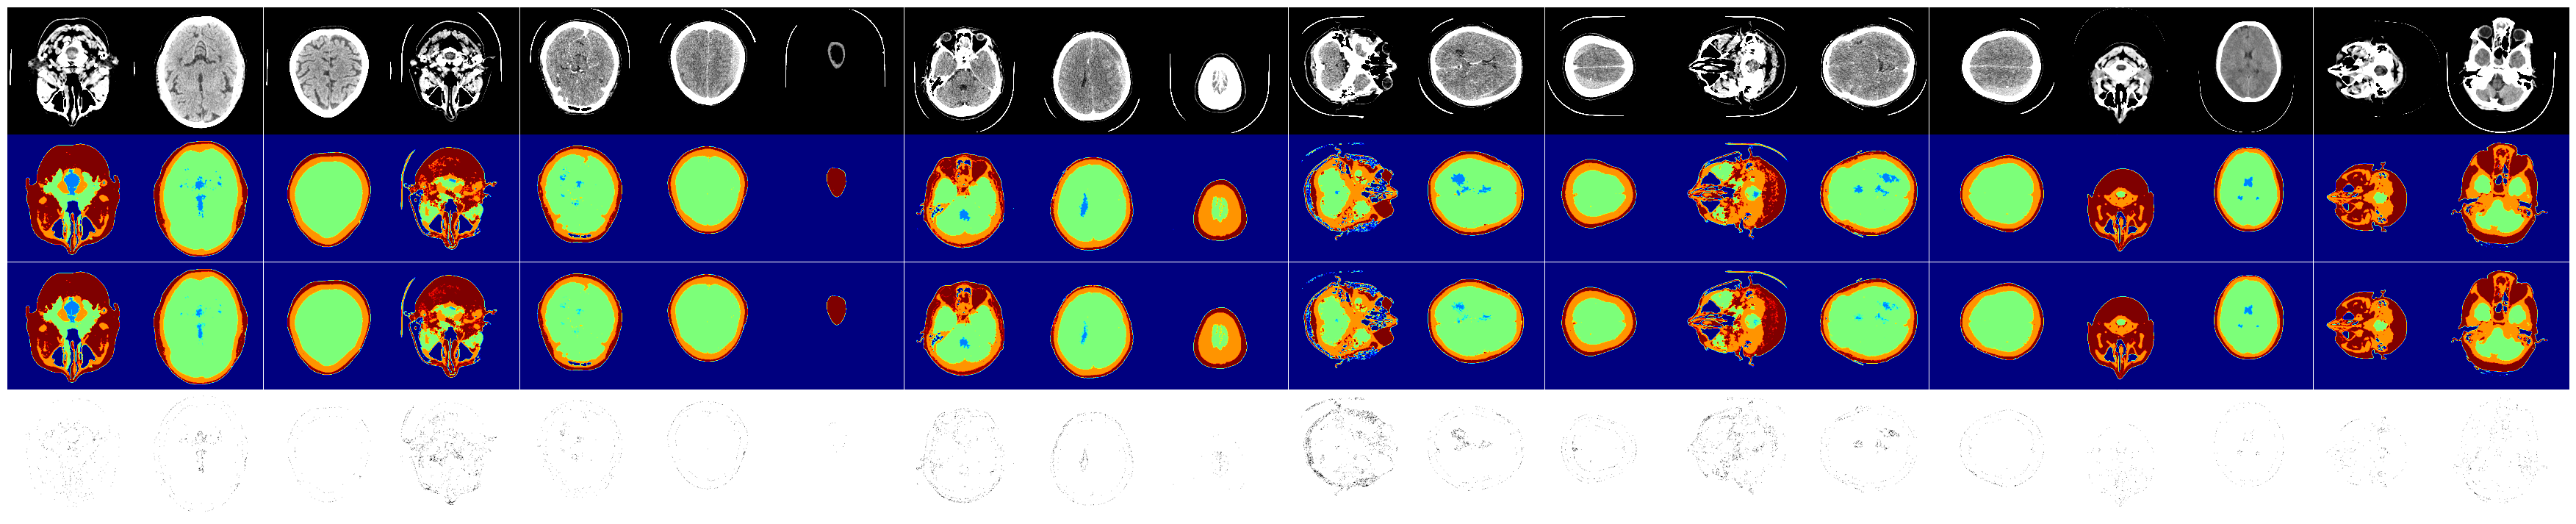

<Figure size 100x100 with 0 Axes>

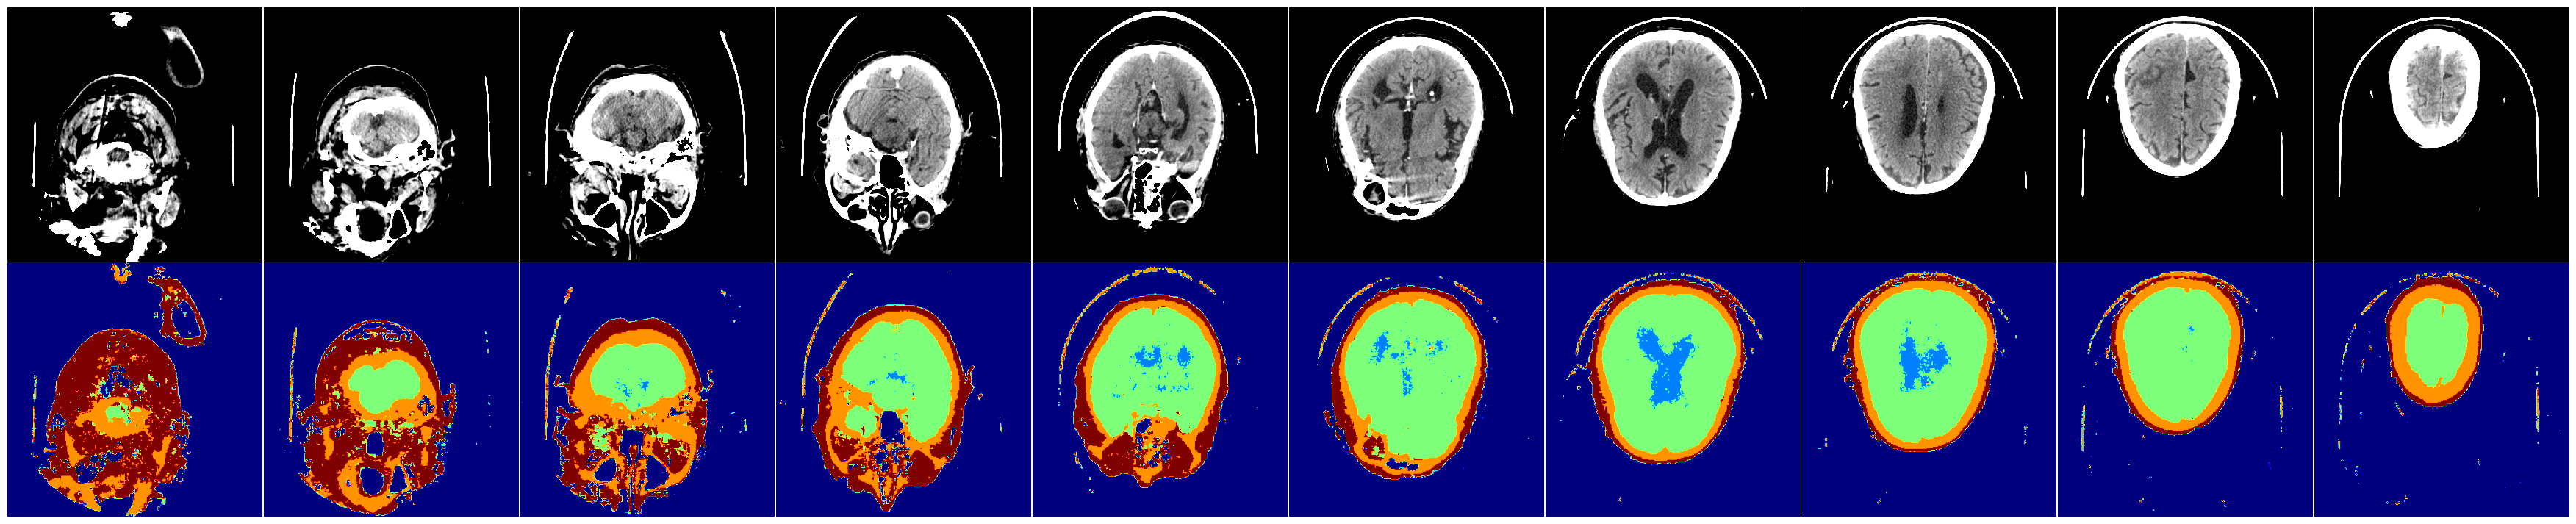

166/166 [==============================] - 31s 188ms/step - loss: 0.2394 - accuracy: 0.9874 - val_loss: 0.0898 - val_accuracy: 0.9770


In [20]:
def add_sample_weights(image, label):
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int64))
    return image, label, sample_weights

unet.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.00025),
            metrics=['accuracy']) 

#training and fine-tuning
hist_2 = unet.fit(train.map(add_sample_weights),
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[DisplayCallback()])

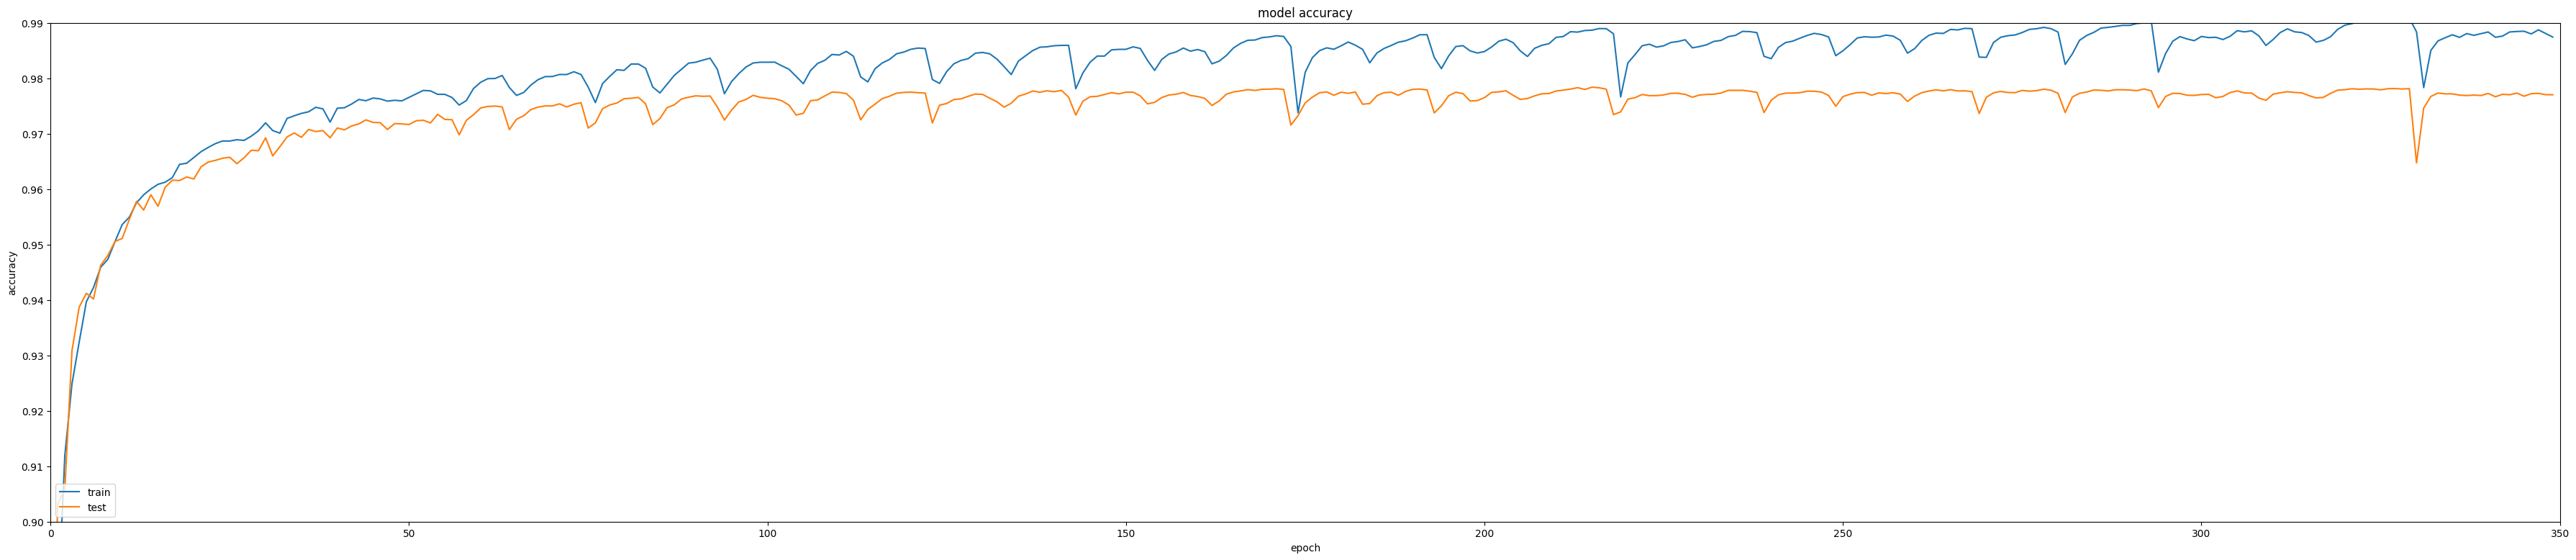

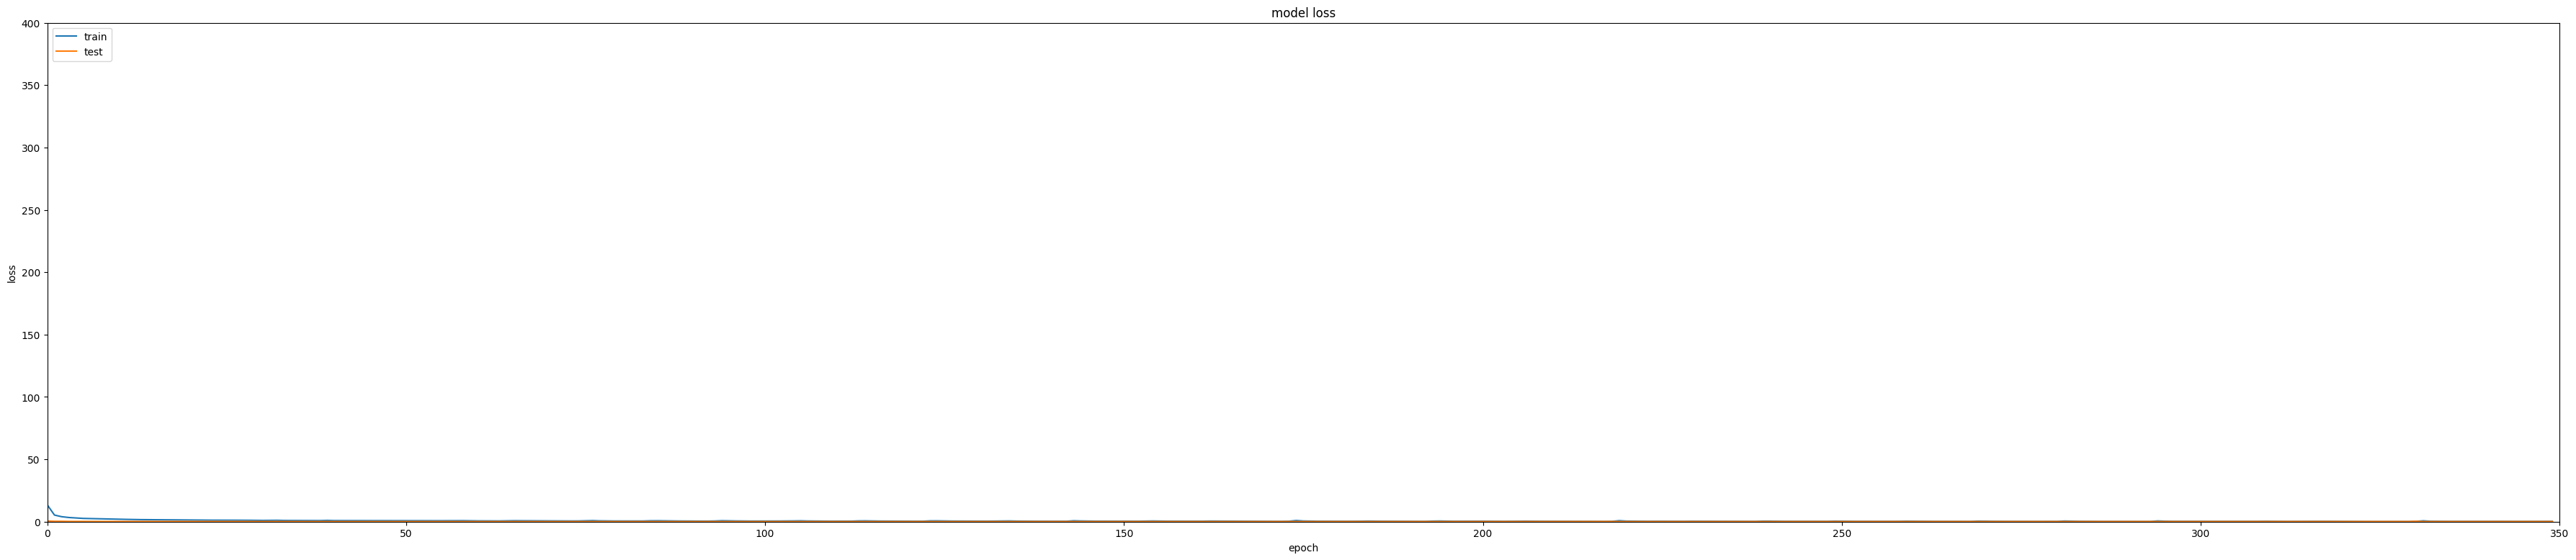

In [21]:
# summarize history for accuracy
plt.plot(hist_2.history['accuracy'])
plt.plot(hist_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.xlim(0, 350)
plt.ylim(0.9, 0.99)
plt.show()
# summarize history for loss
plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.xlim(0, 350)
plt.ylim(0, 400)
plt.show()

In [28]:
# Use image.io to create a gif of the training
import imageio
import glob
anim_file = './UNETpngs/training.gif'

with imageio.get_writer(anim_file, mode='I', duration=250) as writer:
  filenames = glob.glob('./UNETpngs/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

/var/folders/cy/4m985km50zv4pv9z11ycnsqm0000gn/T/ipykernel_96341/969015702.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/var/folders/cy/4m985km50zv4pv9z11ycnsqm0000gn/T/ipykernel_96341/969015702.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


<Figure size 100x100 with 0 Axes>

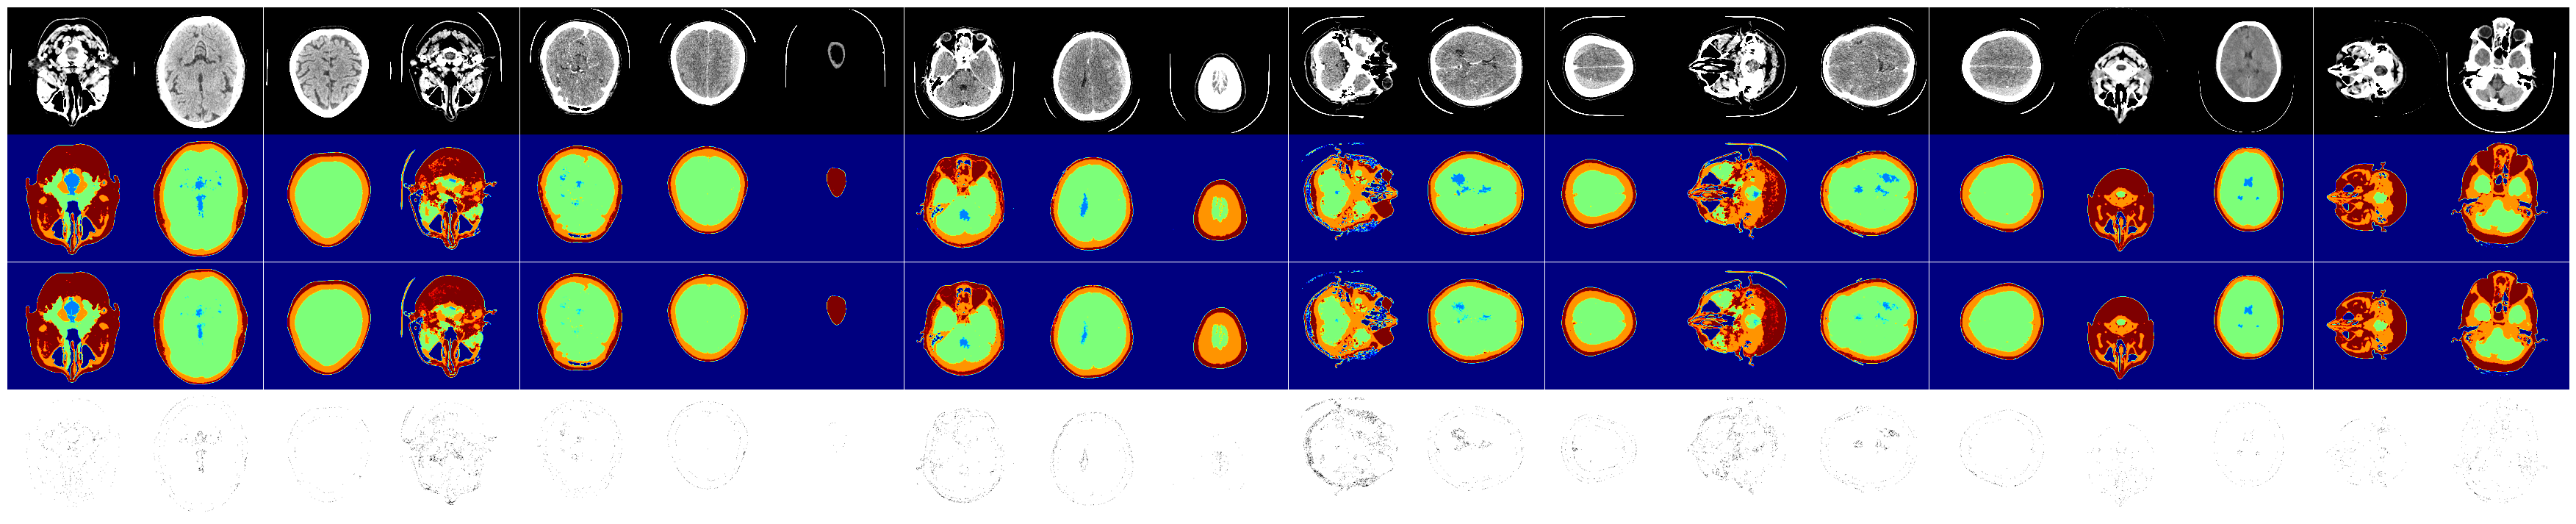

In [23]:
display_everything('<h1>Visualizing Training / Testing Data</h1>',rgb_batch_copy, rgb_batch, label2)

<Figure size 100x100 with 0 Axes>

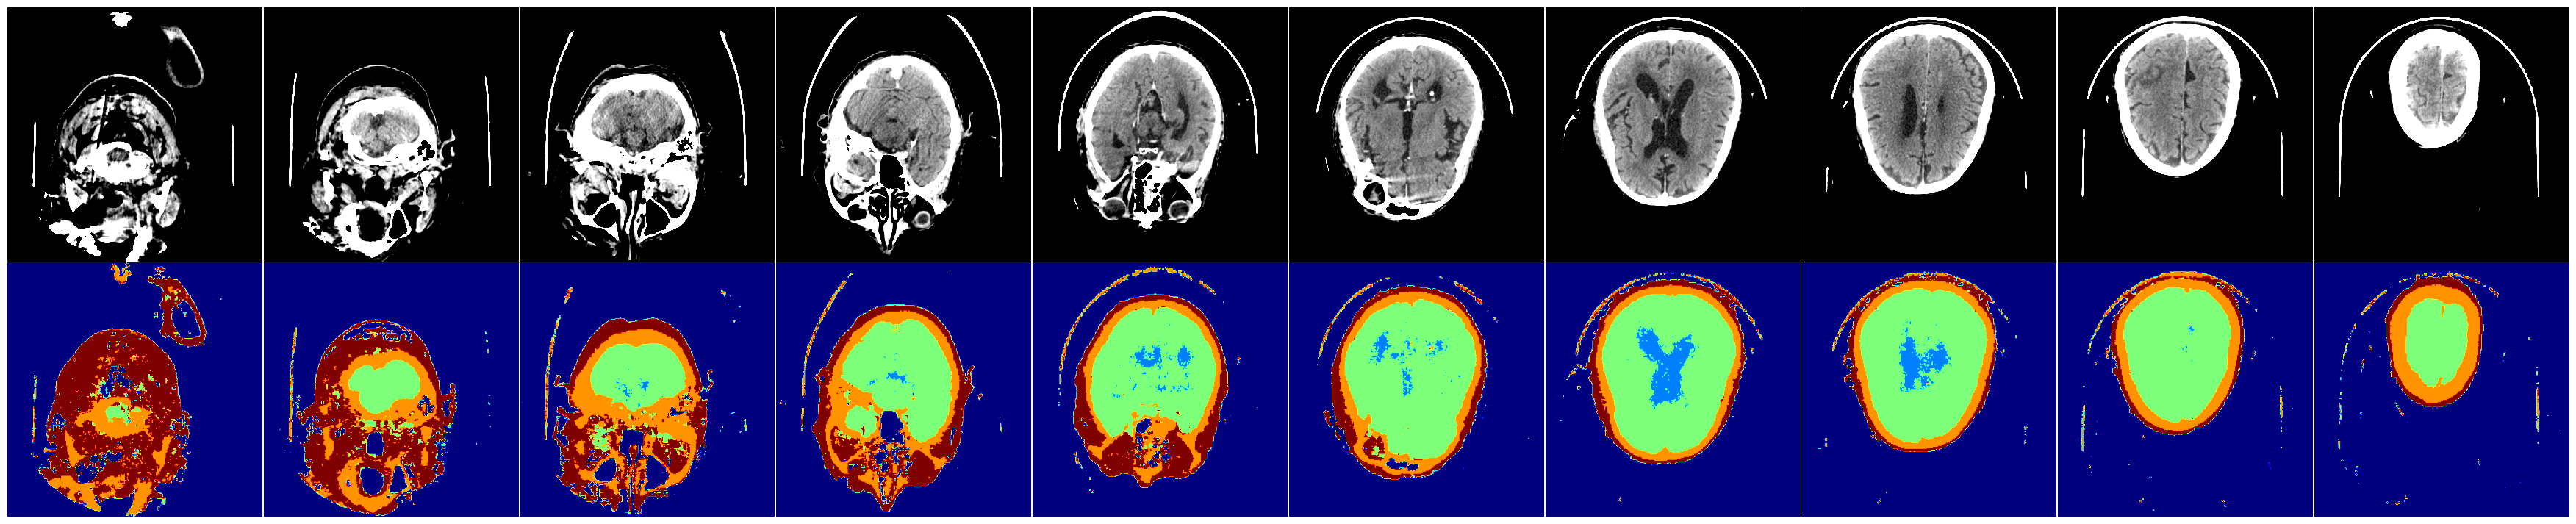

In [24]:
display_everything('<h1>Predictions on NIFTI </h1>',copy_nifti_scan, processed_nifti_scan,cols=10)

<Figure size 100x100 with 0 Axes>

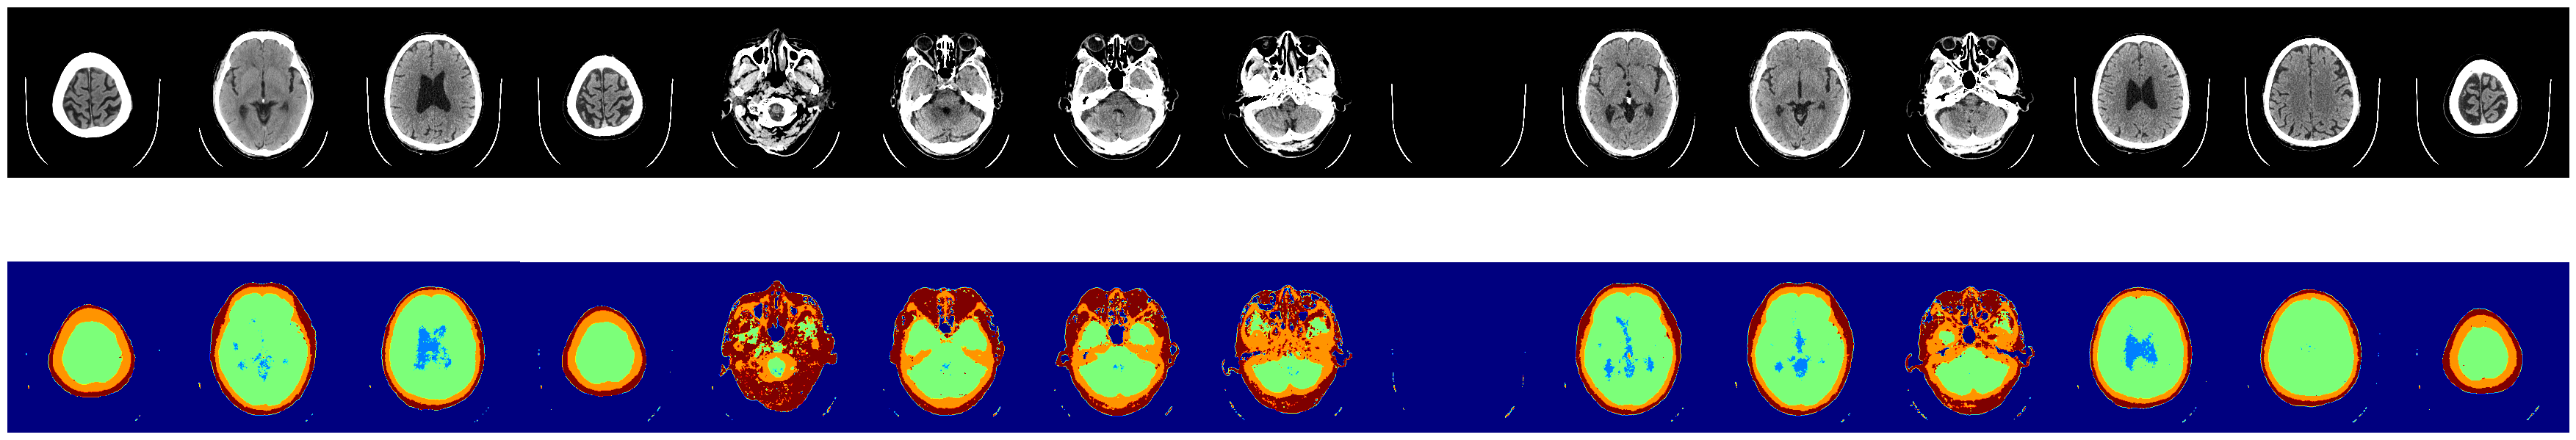

In [25]:
from pydicom.pixel_data_handlers.util import apply_modality_lut

## Populates ArrayDicom & sets up individual scan for prediction
PathDicom = "/Users/andrew/Dropbox/segment/headct/CT20"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))
            
# Get ref file
lstFilesDCM[0]
RefDs = pydicom.dcmread(lstFilesDCM[0])

# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (len(lstFilesDCM), int(RefDs.Rows), int(RefDs.Columns))

# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

# The array is sized based on 'ConstPixelDims'
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    # read the file
    ds = pydicom.dcmread(filenameDCM)
    # store the raw image data
    ArrayDicom[lstFilesDCM.index(filenameDCM), :, :] = apply_modality_lut(ds.pixel_array, ds)

# Load a Testing Scan
dcm_copy    = tf.identity(ArrayDicom)
dcm_resized = tf.image.resize(np.swapaxes(ArrayDicom, 0, 2), (DIMS, DIMS))
dcm_process = preprocess_imgs(dcm_resized)

display_everything('<h1>Predictions on DCM </h1>',dcm_copy, dcm_process,cols=15)

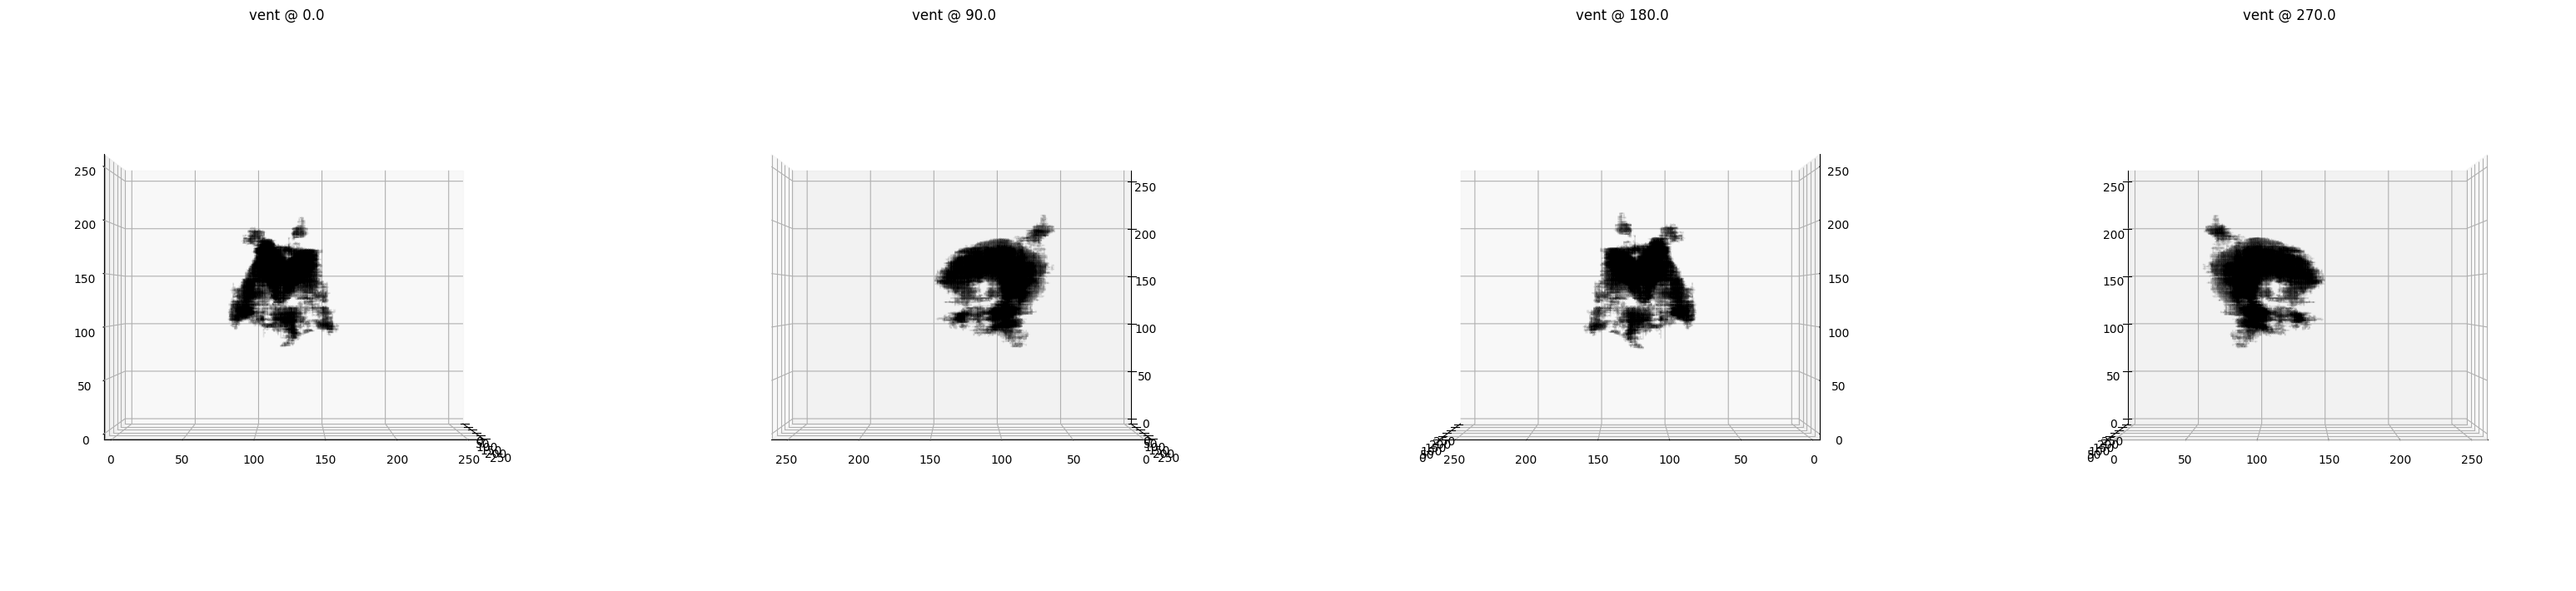

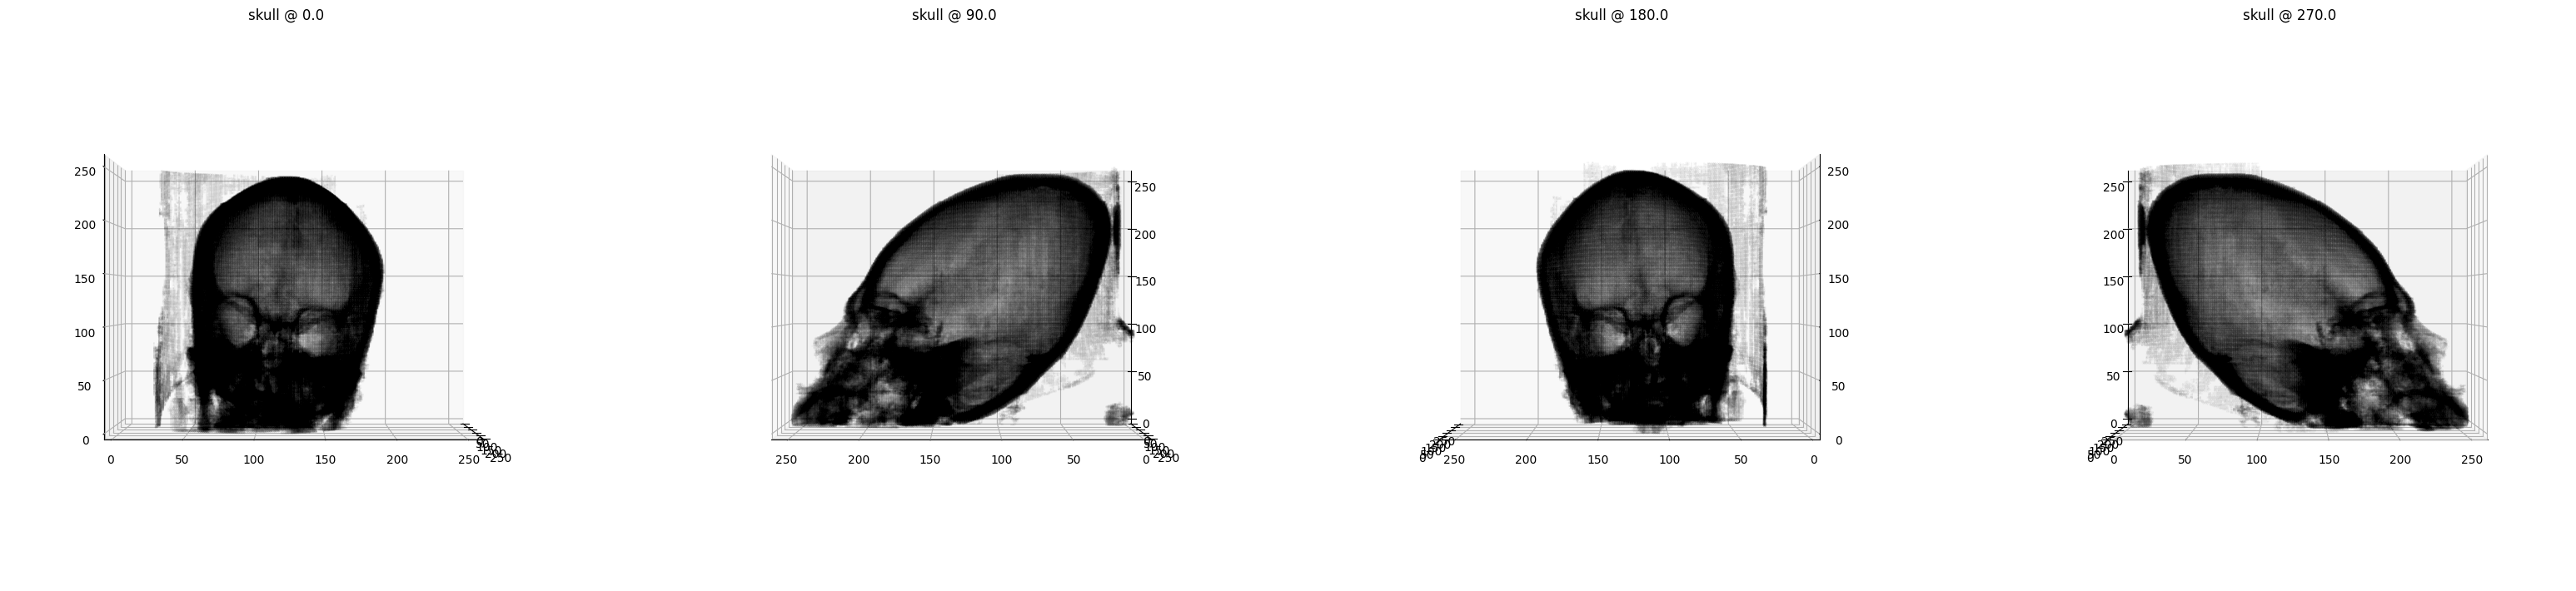

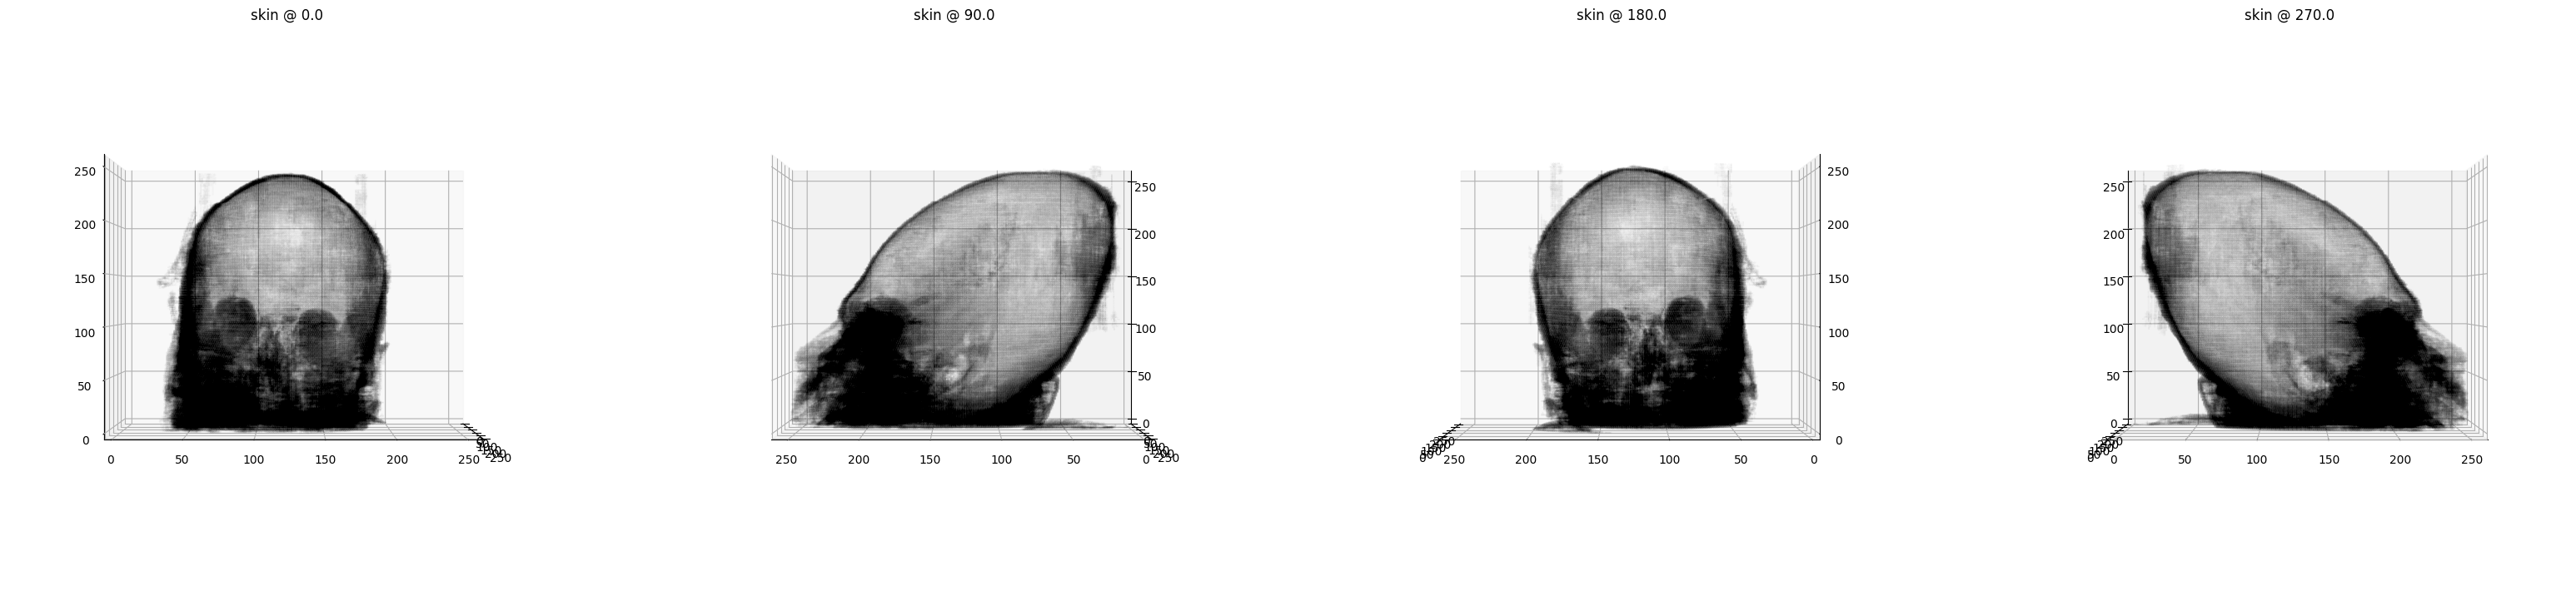

In [26]:
from scipy import ndimage

if(unet is None):
    unet = tf.keras.models.load_model('local_model.h5', compile=False)
# for creating a responsive plot
# %matplotlib widget
 
# importing required libraries
import matplotlib.pyplot as plt

sample_labels = np.zeros((len(processed_nifti_scan), DIMS, DIMS))
for i, slice in enumerate(processed_nifti_scan):
    pred = tf.squeeze(unet.predict(tf.expand_dims(slice, 0), verbose=0))
    sample_labels[i] = tf.argmax(pred, axis=-1).numpy()
    

lbl = ["bckgr", "vent", "brain", "skull", "skin"]
for i, ax in enumerate(lbl):
    if(i>0 and i !=2 ):
        fig = plt.figure(figsize=(50,12))
        gs1 = gridspec.GridSpec(1, 1)
        background = (sample_labels == i).astype(int)
        open_square = ndimage.binary_opening(background, structure=np.ones((3,3,3)))
        eroded_square = ndimage.binary_erosion(open_square, structure=np.ones((5,5,5))).astype(int)
        reconstruction = ndimage.binary_propagation(eroded_square, mask=background)
        z, x, y = reconstruction.nonzero()
        
        rotations = 5
        # 360 Degree view
        for angle in range(1,rotations):
            ang = (450/rotations)*(angle-1)
            ax = fig.add_subplot(1, rotations, angle, projection='3d')
            ax.scatter(x, y, z, c='black', s=0.01*(12-2*i), alpha=0.01*(12-2*i))
            ax.set_xlim(0, DIMS)
            ax.set_ylim(0, DIMS)
            ax.set_zlim(0, background.shape[2])
            ax.set_title("{} @ {}".format(lbl[i], ang))
            ax.view_init(0, ang)
        plt.show()


## Let's load and save the model for coreML

In [27]:
import coremltools as ct
import tensorflow as tf

unet.save('local_model.h5')

unet = tf.keras.models.load_model('local_model.h5', compile=False)

Compile_Model()

model = ct.convert(unet)
model.save('coreML_local_model.mlmodel')

Running TensorFlow Graph Passes: 100%|███████| 6/6 [00:00<00:00, 12.36 passes/s]
Converting TF Frontend ==> MIL Ops: 100%|█| 1181/1181 [00:00<00:00, 3450.99 ops/
Running MIL frontend_tensorflow2 pipeline: 100%|█| 7/7 [00:00<00:00, 184.92 pass
Running MIL default pipeline: 100%|████████| 56/56 [00:02<00:00, 25.34 passes/s]
Running MIL backend_neuralnetwork pipeline: 100%|█| 8/8 [00:00<00:00, 619.63 pas
Translating MIL ==> NeuralNetwork Ops: 100%|█| 1661/1661 [00:00<00:00, 2034.28 o
